In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [2]:
# --- 1. DATA FETCHING ---
symbol = input("Enter the stock symbol (e.g., RELIANCE.NS, ^NSEI): ")
print(f"Fetched data for '{symbol}' using yfinance...")

Fetched data for 'TORNTPOWER.NS' using yfinance...


##### Fetch Live stock data 

In [3]:
try:
    # Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # Fetch historical market data (1 year of daily data)
    data = sym_data.history(period="1y", interval="1d")

    if data.empty:
        raise ValueError(
            f"No data found for symbol '{symbol}'. Please check the ticker."
        )

    # Reset index to make 'Date' a column and keep it as datetime objects
    data = data.reset_index()

    # Select and rename columns for clarity
    data = data[["Date", "Open", "High", "Low", "Close"]]
    data["Date"] = pd.to_datetime(data["Date"])
    # Then format to dd-mm-yyyy
    data["Date"] = data["Date"].dt.strftime("%d-%m-%Y")
    print("\nSuccessfully fetched data. Here are the last 5 data points:")
    print(data.tail().round(2))

except Exception as e:
    print(f"\nAn error occurred: {e}")


Successfully fetched data. Here are the last 5 data points:
           Date    Open    High     Low   Close
246  25-08-2025  1269.3  1290.0  1264.8  1282.5
247  26-08-2025  1282.0  1284.9  1261.1  1270.2
248  27-08-2025  1270.2  1270.2  1270.2  1270.2
249  28-08-2025  1270.2  1271.8  1240.0  1248.3
250  29-08-2025  1241.0  1251.4  1225.0  1227.3


##### Neccesary Data pre-processing steps 

In [4]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T.round(2))

summary statistics  
        count     mean     std      min      25%      50%      75%      max
Open   251.0  1507.30  185.94  1231.87  1374.69  1457.86  1618.53  1950.46
High   251.0  1532.49  191.31  1235.60  1397.51  1476.39  1647.88  2007.62
Low    251.0  1479.64  180.62  1202.97  1355.28  1426.42  1589.57  1921.87
Close  251.0  1503.53  184.80  1227.30  1368.10  1453.77  1617.81  1945.18


##### Stock Price Visualization 

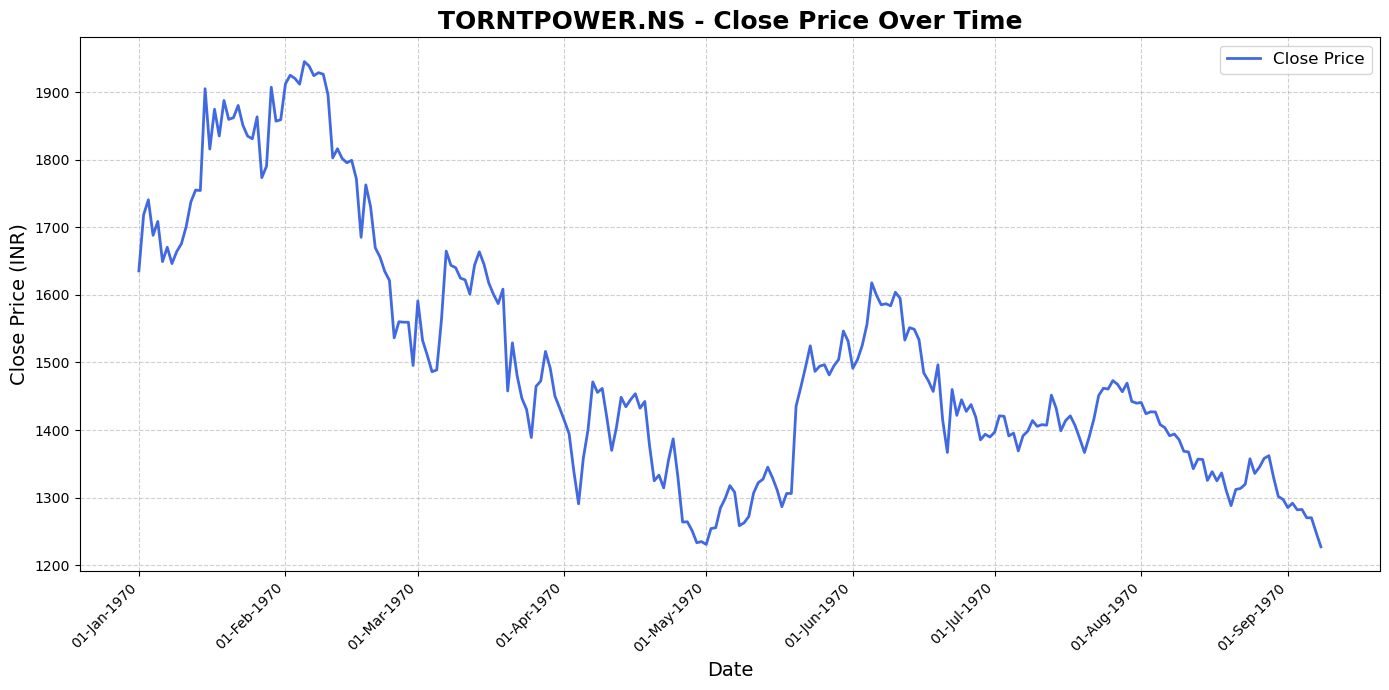

In [5]:
import matplotlib.dates as mdates


plt.figure(figsize=(14, 7))
plt.plot(
    data["Date"], data["Close"], label="Close Price", color="royalblue", linewidth=2
)

# Title and labels
plt.title(f"{symbol} - Close Price Over Time", fontsize=18, fontweight="bold")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price (INR)", fontsize=14)

# Show only a limited number of x-ticks but keep real dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(
    mdates.DateFormatter("%d-%b-%Y")
)  # e.g., 15-Jan-2023

# Rotate and align labels
plt.xticks(rotation=45, ha="right")

plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

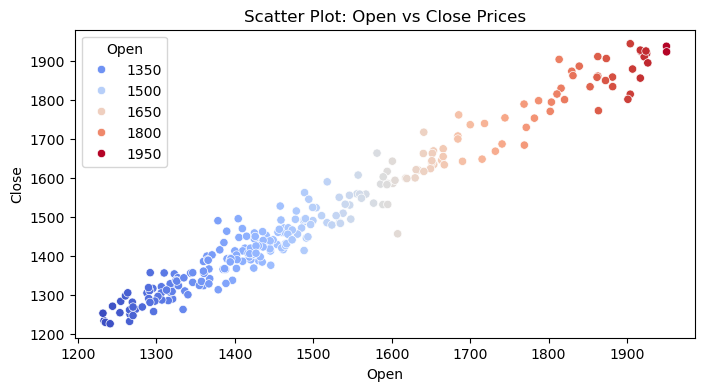

In [6]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

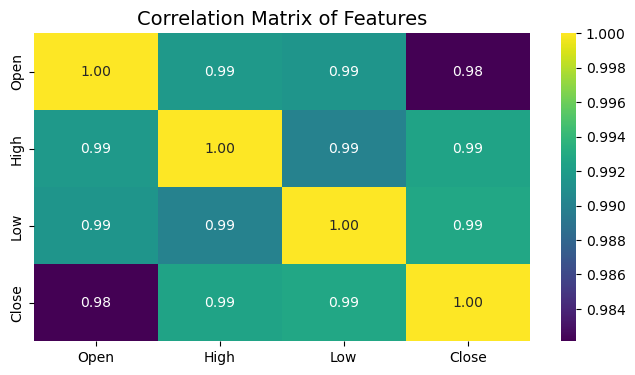

In [7]:
# Heatmap for visualizing correlations
plt.figure(figsize=(8, 4))
numeric_cols = data.select_dtypes(include=np.number)
sb.heatmap(numeric_cols.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [8]:
from scipy.stats import skew
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))

Skewness (Close): 0.7900485252497593
Skewness (Open): 0.7839514128498953
Skewness (High): 0.7855640065024235
Skewness (Low): 0.7836483168507568


#### Skewness Analysis 
- Market data or live time series data has very uneven skewness which is more common and expected due high volatility and other factors on markets

In [ ]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

In [9]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [10]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


           Date    Open    High     Low   Close  Trend
246  25-08-2025  1269.3  1290.0  1264.8  1282.5      0
247  26-08-2025  1282.0  1284.9  1261.1  1270.2      0
248  27-08-2025  1270.2  1270.2  1270.2  1270.2      0
249  28-08-2025  1270.2  1271.8  1240.0  1248.3      0
250  29-08-2025  1241.0  1251.4  1225.0  1227.3      0


### LSTM MODEL

##### 1️⃣ Preparing Your Data for LSTM
###### LSTMs expect 3D input: [samples, timesteps, features]
where
```
samples = number of training examples
timesteps = how many past days to look back
features = number of columns (Open, High, Low, Close, Volume)
```

Step 1: Apply transformations & scaling

In [39]:
# We will use 'Open', 'High', 'Low', 'Close' as features
# features = ["Open", "High", "Low", "Close"]
data_to_scale = data['Close']

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data_to_scale)
scaled_data = scaler.fit_transform(data_to_scale.to_numpy().reshape(-1, 1))

Step 2: Create sequences(timesteps)

In [40]:
# Function to create sequences of data
def create_sequences(dataset, time_steps=60):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        # Sequence of 'time_steps' length
        X.append(dataset[i : (i + time_steps), :])
        # The target is the 'Close' price of the next day
        # Corrected line
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)


# Define the number of time steps (days) to look back
time_steps = 120
X, y = create_sequences(scaled_data, time_steps)

Step 3: Train-test split (no shuffle)

In [41]:
# Split data into training and testing sets 
train_size = int(len(X) * 0.70)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (91, 120, 1), Training labels shape: (91,)
Testing data shape: (40, 120, 1), Testing labels shape: (40,)


Step 4: LSTM model (Keras - RNN variant) 

In [42]:
# --- 4. BUILD AND TRAIN THE LSTM MODEL ---
model = Sequential()
# Layer 1
model.add(
    LSTM(
        units=100,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
model.add(Dropout(0.2))
# Layer 2
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
# Layer 3
model.add(LSTM(units=100))
model.add(Dropout(0.2))
# Output Layer
model.add(Dense(units=1))  # Predicting one value: the next day's price

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

print("\nTraining the model...")
history = model.fit(
    X_train,
    y_train,
    epochs=55,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
)
print("Model training complete.")

c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 120, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 120, 50)        │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 120, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,501 (513.68 KB)

 Trainable params: 131,501 (513.68 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.1041 - val_loss: 0.0110
Epoch 2/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - loss: 0.0470 - val_loss: 0.0120
Epoch 3/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 0.0231 - val_loss: 0.0409
Epoch 4/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - loss: 0.0252 - val_loss: 0.0118
Epoch 5/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - loss: 0.0147 - val_loss: 0.0047
Epoch 6/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 0.0168 - val_loss: 0.0043
Epoch 7/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - loss: 0.0159 - val_loss: 0.0061
Epoch 8/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - loss: 0.0140 - val_loss: 0.0112
Epoch 9/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - loss: 0.0109 - val_loss: 0.0179
Epoch 10/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - loss: 0.0113 - val_loss: 0.0202
Epoch 11/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - loss: 0.0110 - val_loss: 0.0174
Epoch 12/55
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - 

Model evaluation metrics

In [44]:
# --- EVALUATE THE MODEL ---
# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

# Reshape y_test from a 1D array to a 2D array for the scaler
y_test = y_test.reshape(-1, 1)

# Inverse transform directly. No complex placeholders are needed for a single feature.
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# 5. Calculate performance metrics
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 67.54
Mean Absolute Error (MAE): 59.79
R-squared (R2) Score: -0.6001


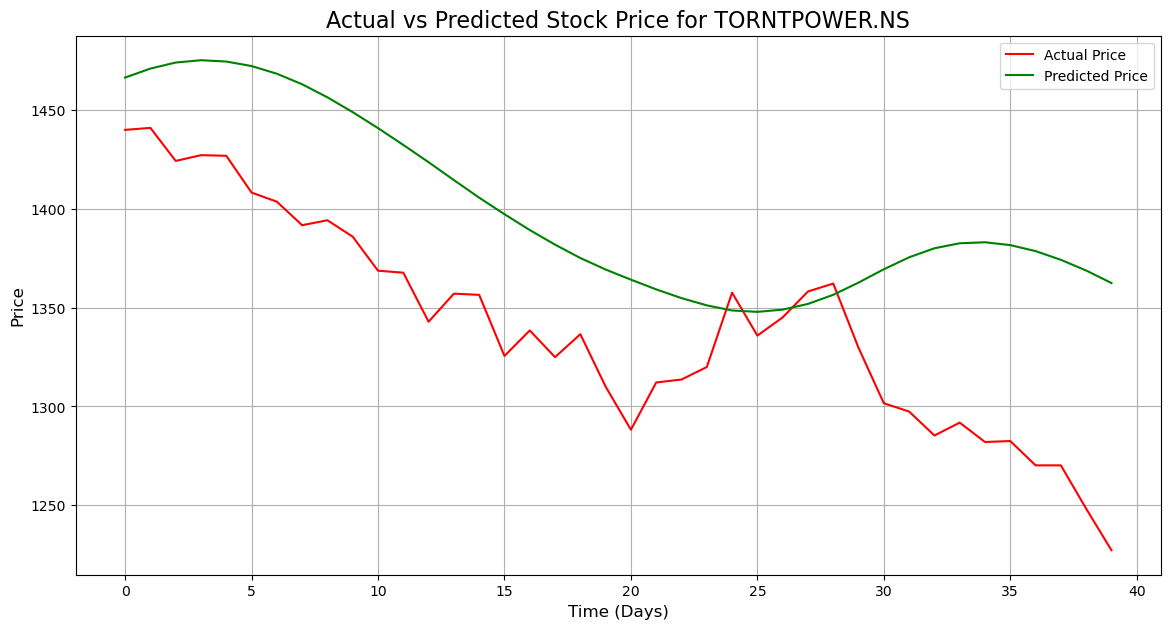

In [45]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='red', label="Actual Price")
plt.plot(y_pred, color='green', label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price for {symbol}", fontsize=16)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [46]:
# --- 6. FORECAST FUTURE PRICES ---
try:
    forecast_days = int(input("\nEnter the number of days to forecast into the future (e.g., 30): "))
    if forecast_days <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Defaulting to 30 days.")
    forecast_days = 15


Forecasting for the next 10 days...

--- Forecasted Prices ---
        Date  Predicted Close
0 2025-08-30      1354.969971
1 2025-08-31      1349.040039
2 2025-09-01      1345.869995
3 2025-09-02      1345.900024
4 2025-09-03      1349.030029
5 2025-09-04      1354.819946
6 2025-09-05      1362.729980
7 2025-09-06      1372.189941
8 2025-09-07      1382.699951
9 2025-09-08      1393.849976


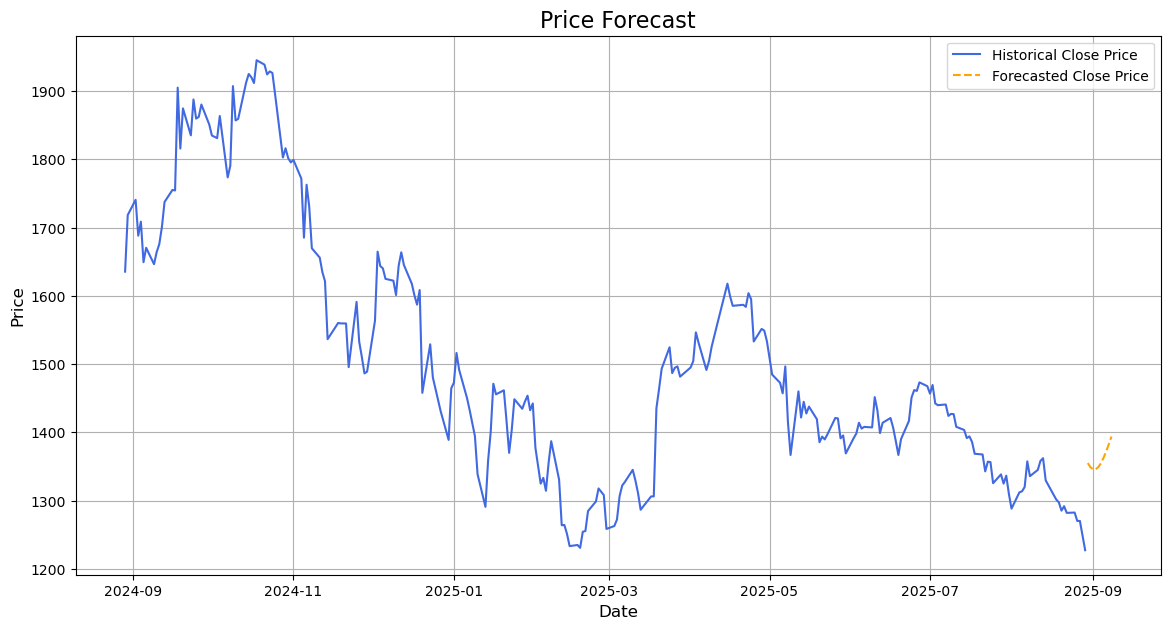

In [48]:
# --- 6. FORECAST FUTURE PRICES ---
try:
    forecast_days = int(
        input("\nEnter the number of days to forecast into the future (e.g., 30): ")
    )
    if forecast_days <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Defaulting to 30 days.")
    forecast_days = 30

# Use the last 'time_steps' from the single-feature scaled data as the starting point
last_sequence = scaled_data[-time_steps:].flatten() # Start with a 1D array
forecast_predictions_scaled = []

current_input = last_sequence

print(f"\nForecasting for the next {forecast_days} days...")

for _ in range(forecast_days):
    # Reshape the current input to what the model expects: (1, time_steps, 1)
    current_input_reshaped = current_input.reshape((1, time_steps, 1))
    
    # Predict the next day's scaled price
    pred_scaled = model.predict(current_input_reshaped, verbose=0)[0, 0]
    forecast_predictions_scaled.append(pred_scaled)
    
    # Update the input sequence for the next prediction:
    # Drop the first value and append the new prediction at the end
    current_input = np.append(current_input[1:], pred_scaled)

# Inverse transform the forecast predictions (this is much simpler now)
forecast_prices = scaler.inverse_transform(np.array(forecast_predictions_scaled).reshape(-1, 1))

# --- The rest of your plotting code is correct ---

data["Date"] = pd.to_datetime(data["Date"])

# Create future dates for the forecast
last_date = data["Date"].iloc[-1]
# You may need to import timedelta: from datetime import timedelta
from datetime import timedelta
future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]

# Create and display the forecast DataFrame
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted Close": forecast_prices.flatten()})
print("\n--- Forecasted Prices ---")
print(forecast_df.round(2))

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(data["Date"], data["Close"], label="Historical Close Price", color="royalblue")
plt.plot(
    forecast_df["Date"],
    forecast_df["Predicted Close"],
    label="Forecasted Close Price",
    color="orange",
    linestyle="--",
)
plt.title("Price Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()